# Tuning kNN with 142 models -- A Deep Dive into Learning by Proximity

In this notebook, we'll explore **k-Nearest Neighbors** or, kNN for short, an intuitive and powerful machine learning algorithm that makes predictions based on proximity. Here's a high-level explanation of *how* this deceptively simple ML model works:

**kNN** looks at the label of the most similar observation to predict what label should be attached to a new observation. But we don't have to tell the model to look at just 1 neighbor -- we can ask it to look at 2 neighbors, or 3 neighbors, or way more than that. So, the question becomes: **What's the optimal number of neighbors to ask?** And that's how we ended up building not 1 model or, 2 or 3 -- but **142**.

Before we dive in, here's a quick snapshot of the trail we'll be following:

**The Pipeline**:

- Load and explore a popular dataset from **scikit-learn**
- Visualize the dataset: Plot first, model second
- Split the training and test sets
- Build the kNN Classifier and fit the model
- Predict on the test set and evaluate the accuracy
- One more visualization

## Load and explore a popular dataset from scikit-learn

While **scikit-learn** is best known as a machine learning library, it also offers [toy datasets](https://scikit-learn.org/stable/datasets/toy_dataset.html) that don't require any downloads and can be easily loaded into any Jupyter Notebook. For this deep dive, we'll pick a fun one -- **Dataset 8.1.5**, or, the Wine Recognition Dataset.

In [4]:
# Import the Wine Recognition Dataset from sklearn.datasets
from sklearn.datasets import load_wine

# Save the dataset into a variable
wine_data = load_wine()

Now that we've loaded the dataset let's take a look at what we are working with.

In [7]:
#Display the Wine Recognition Dataset
wine_data

{'data': array([[1.423e+01, 1.710e+00, 2.430e+00, ..., 1.040e+00, 3.920e+00,
         1.065e+03],
        [1.320e+01, 1.780e+00, 2.140e+00, ..., 1.050e+00, 3.400e+00,
         1.050e+03],
        [1.316e+01, 2.360e+00, 2.670e+00, ..., 1.030e+00, 3.170e+00,
         1.185e+03],
        ...,
        [1.327e+01, 4.280e+00, 2.260e+00, ..., 5.900e-01, 1.560e+00,
         8.350e+02],
        [1.317e+01, 2.590e+00, 2.370e+00, ..., 6.000e-01, 1.620e+00,
         8.400e+02],
        [1.413e+01, 4.100e+00, 2.740e+00, ..., 6.100e-01, 1.600e+00,
         5.600e+02]]),
 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

The immediate observation is that this is most certainly *not* a DataFrame.

In [8]:
# Check the type
type(wine_data)

sklearn.utils._bunch.Bunch

What we're working with is a **Bunch** -- effectively *a dictionary on steroids*. Those curly brackets were a hint. 

This Bunch object can be accessed with keys with either square brackets (`bunch['data']`) or dot notation (`bunch.data`). And, as we're about to see, comes preloaded with convenient fields. So, now back to those keys.

In [9]:
# Let's take a look at the keys of the dataset using .keys()
print("Keys of wine_data:\n", wine_data.keys())

Keys of wine_data:
 dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names'])


Here's the list in a cleaner output:
- `data` - feature matrix (X)
- `target`-labels (y)
- `frame` - optional pandas DataFrame version
- `target_names`- label names, like ‘class_0’ and ‘class_0’
- `DESCR` - description of the dataset
- `feature_names` - feature names (as we'll see in detail below)

We'll begin by exploring the `DESC` key.

In [23]:
# Let's explore the 'DESC' or description key
# The 'DESCR' key holds a long text block describing the dataset
print(wine_data['DESCR'])

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

:Number of Instances: 178
:Number of Attributes: 13 numeric, predictive attributes and the class
:Attribute Information:
    - Alcohol
    - Malic acid
    - Ash
    - Alcalinity of ash
    - Magnesium
    - Total phenols
    - Flavanoids
    - Nonflavanoid phenols
    - Proanthocyanins
    - Color intensity
    - Hue
    - OD280/OD315 of diluted wines
    - Proline
    - class:
        - class_0
        - class_1
        - class_2

:Summary Statistics:

============================= ==== ===== ======= =====
                                Min   Max   Mean     SD
============================= ==== ===== ======= =====
Alcohol:                      11.0  14.8    13.0   0.8
Malic Acid:                   0.74  5.80    2.34  1.12
Ash:                          1.36  3.23    2.36  0.27
Alcalinity of Ash:            10.6  30.0    19.5   3.3
Magnesium:                    70.0 162.0    99.7  14.3

Now, to examine the target names and feature names.

In [14]:
# Display the target names
print("Target names:", wine_data['target_names'])

Target names: ['class_0' 'class_1' 'class_2']


In [15]:
# Now display the feature names
print("Feature names:", wine_data['feature_names'])

Feature names: ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']


Let's confirm just how many features there are.

In [25]:
# Use len() to quickly check how many features there are
len(wine_data['feature_names'])

13

### Wine Recognition Dataset Overview

After reviewing the dataset, let's quickly summarize it:

- **178** instances or wine samples
- **30** features or attributes for each -- think: Alcohol, Malic Acid, Ash and so on
- **3** wine classes  -- each representing a different cultivar, or grape variety)

As we saw in the description, all the samples come from the same region in Italy but represent different cultivars based on their chemical profile. So, while all wines may be red, the model’s job is to distinguish between subtle variations -- a perfect challenge for a classification algorithm.

At this point, the model *almost builds itself*. Our task:  

Train a machine learning model that predicts the cultivar of a given wine based on its chemical makeup.

## Visualize the dataset: Plot first, model second

It's always a good idea to visualize the data before diving into the modeling. This helps with revealing patterns, spotting outlers and assessing the dataset at large. As alwasy: **Plot first, model second**.

In [29]:
# First, turn the dataset into a DataFrame
# Start with the imports
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
wine = pd.DataFrame(wine_data['data'], columns=wine_data['feature_names'])
wine['target'] = wine_data['target']
wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


Let's quickly check the shape.

In [30]:
# Check the shape
wine.shape

(178, 14)

Next let's take a look at the class balance.

In [36]:
# Use .value_counts() to check the balance of the DataFrame
wine['target'].value_counts()

target
1    71
0    59
2    48
Name: count, dtype: int64

And now to visialize the above distribution with a simple bar plot.

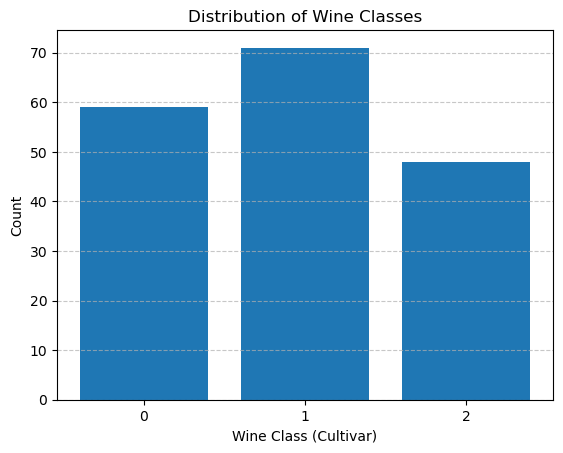

In [63]:
# Get the class counts and sort them by class
class_counts = wine['target'].value_counts().sort_index()
class_counts

# Plot the class distribution with matplotlib
plt.bar(class_counts.index, class_counts.values) # Bar chart: x = class, y = count
plt.title ('Distribution of Wine Classes') # Set the title for the graph
plt.xlabel('Wine Class (Cultivar)') # Set the x-label with class info
plt.ylabel('Count') # Set the y-label with the number of samples
plt.xticks([0, 1, 2]) # Make sure the labels show up as 0, 1, 2 per actual classes
plt.grid(axis='y', linestyle='--', alpha=0.7) # Add light horizontal gridlines for readability

# Display the plot
plt.show()

Before we move on to modeling, let's punch up the visualzations. Like we said, **plot first (maybe twice), model second**. to further our understanding of the dataset, let's take a look at the distribution of alcohol content by wine class.

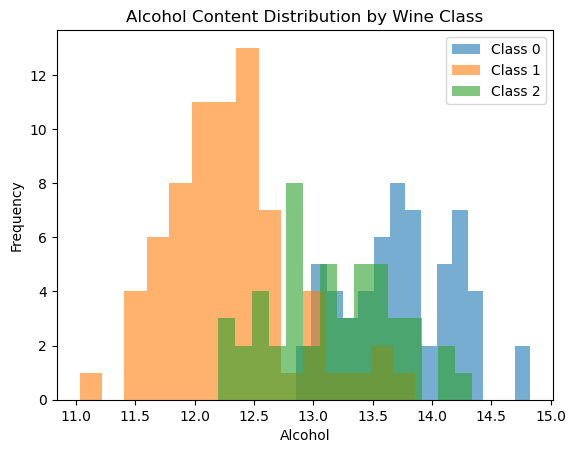

In [69]:
# Create a histogram of alcohol content grouped by wine class

# Start with a for loop that loops over each unique class label (0, 1, 2)
for label in wine['target'].unique():
    # Now, filter the DataFrame to just one class and plot its 'alcohol' values
    plt.hist(
        wine[wine['target'] == label]['alcohol'], 
        bins=15, # The number of bins determines the number of bars in the histogram
        alpha=0.6, # Use semi-transparent (set alpha to 0.6) so that the histograms can overlap
        label=f'Class {label}') # Create a dynamic label for the legend

plt.title('Alcohol Content Distribution by Wine Class') # Set the title for the plot
plt.xlabel('Alcohol') # Add the x-label for the feature being visualized
plt.ylabel('Frequency') # Add the y-label for how often each value appears
plt.legend() # Add a legend to distinguish the classes visually

# Display the plot
plt.show()

And now, we're ready to start building our model.

## Split the training and test sets

To prepare our dataset for modeling, we'll execute an 80/20 split between the training set and the test set. We begin by setting **X** -- our features -- and **Y** -- our targets.

In [78]:
# Set X, the featyre variables
# Important note: We need to drop the target variable
X = wine.drop('target', axis=1)

In [72]:
# Check the shape of X
X.shape

(178, 13)

In [73]:
# Check the type
type(X)

pandas.core.frame.DataFrame

In [75]:
# Now set y, the target
y = wine['target']

In [76]:
# Check the shape of y
y.shape

(178,)

In [77]:
# Check the type
type(y)

pandas.core.series.Series

Next we'll import `train_test_split` from `sklearn.model_selection` to knock out the 80/20 split.

In [79]:
# Import test_train_split from sklearn model selection
from sklearn.model_selection import train_test_split

# Split the features and labels into training and test sets; 80% goes to training, 20% to testing 
# Also: set the random_state to 0 so that we can replicate the results
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

In [80]:
# Display the shape of the X_train and y_train datasets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (142, 13)
y_train shape: (142,)


In [81]:
# Now display the shape of the X_test and y_test datasets
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_test shape: (36, 13)
y_test shape: (36,)


In [88]:
# As we would expect, X_train + X_test = the length of the whole dataset
len(X_train + X_test)

178

In [164]:
# And, of course, the same for y
len(y_train + y_test)

569

And, just to double check that 80/20 split...

In [86]:
# Check the percentage of X_train
len(X_train) / len(wine)

0.797752808988764

In [89]:
# And check the percentage of X_test
len(X_test) / len(wine)

0.20224719101123595

## Build the kNN Classifier and fit the model

Before we start building, let's explain, intuitively, *how* kNN works:

**kNN** looks at the label (hello, **target variable**) of the most similar observation to predict what label should be attached to a new observation. But we can also tell the model to look at 2 neighbors, or 3 neighbors, or way more than that. What we're about to figure out is: What's the optimal number of neighbors to ask?

To begin, we'll build models with n_neighbors = {1, 2, 3, 4, 5}, compare performance on the training and test set and see what the data tells us.

In [90]:
# To begin, import the KNN classifier from sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier

# Initialize the model 
# Note: We begin by setting the model to n_neighbors=1, which means it only considers the closest neighbor
knn_1 = KNeighborsClassifier(n_neighbors=1)
knn_1

KNeighborsClassifier(n_neighbors=1)

Next, we fit the model on the training set -- X_train and y_train.

In scikit-lean, `.fit()` is where the *real* learning begins. What we're doing with this code is asking the model to **memorize the training data** -- not to draw patterns like we'd see in a traditional regression model. Instead, our model is storing the coordinates of *every* observation.

This process is why kNN is known as a **lazy learner** -- it doesn't *train* in the classic sense. Instead, it waits until we feed it a new observation and then looks areound at the training set to see who's nearby. And, for now, that *who* is just the closest neighbor.

In [91]:
# Use .fit() to fit the the model on the training set
knn_1.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

## Predict on the test set and evaluate the accuracy

Now comes the critical step -- deploying our trained model to make predictions on the test set, or **unseen data**. This step allows us to evaluate how well our model generalizes beyond the training set, which, as we know, the model *memorized*.

In [92]:
# Predict on the test set, or X_test using the .predict() method
y_pred = knn_1.predict(X_test)

In [93]:
# Display the predictions
y_pred

array([0, 1, 1, 0, 1, 1, 0, 2, 1, 1, 0, 1, 0, 2, 2, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 2, 2, 0, 0, 2, 0, 0, 0])

As would be expected, the above *predictions* all correspond to our three class labels: 0, 1 and 2. Next, we'll use the `.score()` method from scikit-learn to compare the model's predictions with the *actual* labels in the test set.

In [94]:
# Now to check the accuracy with .score()
print('Test set score: {:.2f}'.format(knn_1.score(X_test, y_test)))

Test set score: 0.78


78%!

Not bad, but also not great. 

As we laid out before, the idea is to see if we can do better, to find the optimal number of neighbiors. 2, 3, 4, 5? Instead of re-running this pipeline four more times, **let's scale our efforts by writing a `for` loop**.

In [99]:
# Begin by defining the range, or the number of neighbors
for k in range(1,6):
    knn = KNeighborsClassifier(n_neighbors=k) # Set the classifier type using kNN
    knn.fit(X_train, y_train) # Fit the model on the training sets
    score = knn.score(X_test, y_test) # Use .score() to evaluate the model's accuracy on the test set
    print(f'k={k}, test accuracy = {score:.2f}') # Print the test accuracy, or score, for each model

k=1, test accuracy = 0.78
k=2, test accuracy = 0.75
k=3, test accuracy = 0.78
k=4, test accuracy = 0.75
k=5, test accuracy = 0.81


**Initial takeway**: Our kNN model with `n_neighbors=5` achieved the highest accuracy (**81%**) on the test set. The above results demonstrate that increasing n_neighbors can reduce overfitting and help the models more effectively generalize to unseen data.

## One more visualization

Just for fun, let's loop through all the samples and find the most accurate number of neighbors of all. Then, once we've run our supercharged `for` loop, we'll bring it to life with one final visualization.

We know there are **178** obsevations in our dataset, but our training set consists of just 80% of that or 142 observations. So, we'll set out `for` loop accordingly because the largest valid value for `k` is the length of the training set. If we went beyond that, the model would try to include *more* neighbors than exist in the training set, which would be a problem.

In [103]:
# Build the supercharged for loop
# Begin by defining the range, or the number of neighbors
for k in range(1,143):
    knn = KNeighborsClassifier(n_neighbors=k) # Set the classifier type using kNN
    knn.fit(X_train, y_train) # Fit the model on the training sets
    score = knn.score(X_test, y_test) # Use .score() to evaluate the model's accuracy on the test set
    print(f'k={k}, test accuracy = {score:.2f}') # Print the test accuracy, or score, for each model

k=1, test accuracy = 0.78
k=2, test accuracy = 0.75
k=3, test accuracy = 0.78
k=4, test accuracy = 0.75
k=5, test accuracy = 0.81
k=6, test accuracy = 0.75
k=7, test accuracy = 0.78
k=8, test accuracy = 0.69
k=9, test accuracy = 0.75
k=10, test accuracy = 0.72
k=11, test accuracy = 0.72
k=12, test accuracy = 0.69
k=13, test accuracy = 0.75
k=14, test accuracy = 0.72
k=15, test accuracy = 0.72
k=16, test accuracy = 0.75
k=17, test accuracy = 0.78
k=18, test accuracy = 0.75
k=19, test accuracy = 0.78
k=20, test accuracy = 0.78
k=21, test accuracy = 0.75
k=22, test accuracy = 0.75
k=23, test accuracy = 0.75
k=24, test accuracy = 0.75
k=25, test accuracy = 0.75
k=26, test accuracy = 0.75
k=27, test accuracy = 0.75
k=28, test accuracy = 0.75
k=29, test accuracy = 0.75
k=30, test accuracy = 0.75
k=31, test accuracy = 0.75
k=32, test accuracy = 0.75
k=33, test accuracy = 0.75
k=34, test accuracy = 0.75
k=35, test accuracy = 0.75
k=36, test accuracy = 0.75
k=37, test accuracy = 0.75
k=38, test

A quick scroll through the above output reveals that the highest accuracy (**83%**) was achieved when 'k' was set between 95 and 104 -- a surprisingly large number of neighbors. The result highlights a key insight: in this **three-class classification problem**, using a bigger neighborhood helped smooth out local noise and improve generalization -- without overwhelming the model with bias from the majority class. 

Now, let's bring it all together with our plot.

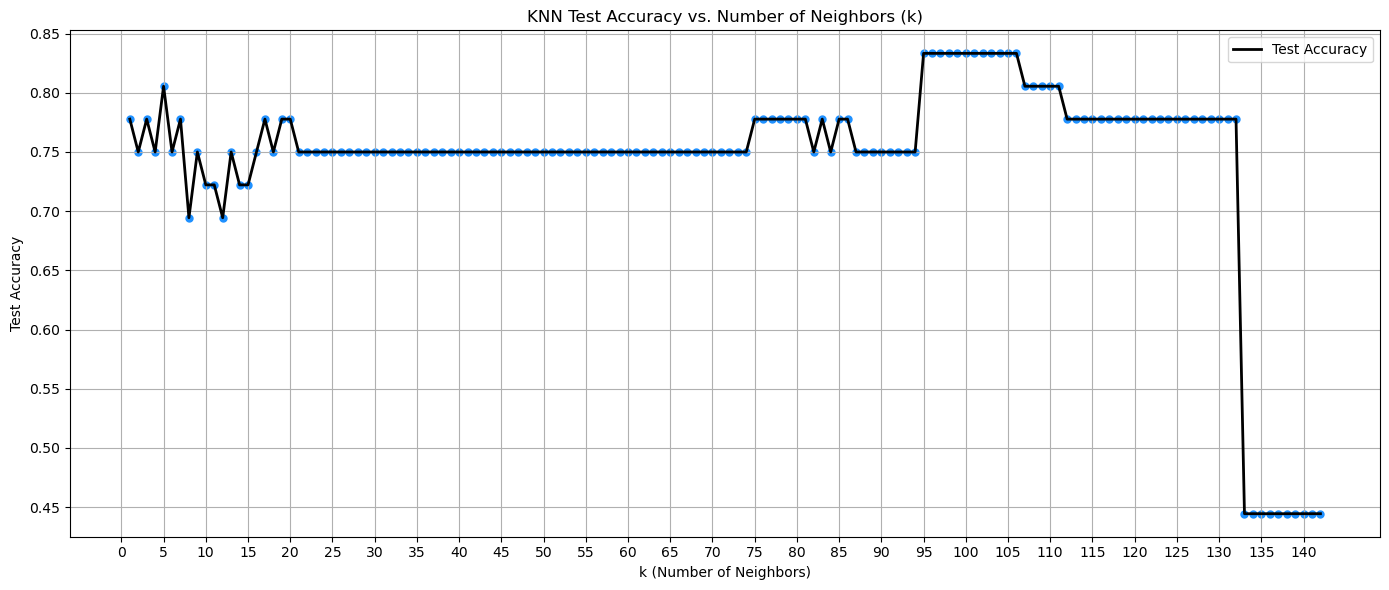

In [153]:
# Initialize lists to store values
k_values = []
accuracy_scores = []

# Loop through our supercharged for loop and store the test accuracy
for k in range(1, 143):
    knn = KNeighborsClassifier(n_neighbors=k) # Intialize kNN model with k neighbors
    knn.fit(X_train, y_train) # Fit the model to the training data
    score = knn.score(X_test, y_test) # Evaluate test accuracy
    k_values.append(k) # Save current k
    accuracy_scores.append(score) # Save the corresponding test accuracy


# Create the plot
plt.figure(figsize=(14, 6)) # Set the plot size
plt.plot(k_values, accuracy_scores, color='black', label='Test Accuracy', linewidth=2) # Lien plot showing accuracy
plt.scatter(k_values, accuracy_scores, color='dodgerblue', s=25) # Add dots to highligth individual k-values
plt.title('KNN Test Accuracy vs. Number of Neighbors (k)') # Set the title
plt.xlabel('k (Number of Neighbors)') # Set the x-label
plt.ylabel('Test Accuracy') # Set the y-label
plt.xticks(range(0, 143, 5)) # Set x-ticks every 5 units
plt.grid(True) # Add gridlines
plt.legend() # Show the legend
plt.tight_layout() # Prevent overlapping elements

# Display the plot
plt.show()

While our chart doesn't reveal a dramatic tipping point, it does show how accuracy ebbs and flows -- and ultimately peaks -- before absolutely falling off a cliff. **In short**: tuning isn't optional. It can make -- or break -- your model.